**This notebook focuses on the effectiveness of PixelDefend against adversarial attacks on the MNIST and MARVEL datasets.**

## **Section 0 - Setting Up**

### **Load prerequisites**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, Layer

from keras_radam import RAdam

import cv2
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from art import config
from art.attacks.evasion import FastGradientMethod, DeepFool, ProjectedGradientDescent, SaliencyMapMethod, CarliniL2Method, NewtonFool, BasicIterativeMethod
from art.defences.preprocessor import PixelDefend
from art.defences.trainer import AdversarialTrainer
from art.estimators.classification import KerasClassifier, TensorFlowV2Classifier
from art.utils import load_mnist

## Build a PixelCNN for PixelDefend to use

### Tensorflow probability method

In [91]:
# Build a small Pixel CNN++ model to train on MNIST.

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfd = tfp.distributions
tfk = tf.keras
tfkl = tf.keras.layers

# tf.enable_v2_behavior()

# Load MNIST from tensorflow_datasets
data = tfds.load('mnist')
train_data, test_data = data['train'], data['test']

def image_preprocess(x):
  x['image'] = tf.cast(x['image'], tf.float32)
  return (x['image'],)  # (input, output) of the model

batch_size = 16
train_it = train_data.map(image_preprocess).batch(batch_size).shuffle(1000)

image_shape = (28, 28, 1)
# Define a Pixel CNN network
dist = tfd.PixelCNN(
    image_shape=image_shape,
    num_resnet=1,
    num_hierarchies=2,
    num_filters=32,
    num_logistic_mix=5,
    dropout_p=.3,
)

# Define the model input
image_input = tfkl.Input(shape=image_shape)

# Define the log likelihood for the loss fn
log_prob = dist.log_prob(image_input)

# Define the model
model = tfk.Model(inputs=image_input, outputs=log_prob)
model.add_loss(-tf.reduce_mean(log_prob))

# Compile and train the model
model.compile(
    optimizer=tfk.optimizers.Adam(.001),
    metrics=[])

# model.fit(train_it, epochs=1, verbose=True)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


### Keras Method

In [2]:
# Build a small Pixel CNN++ model to train on MNIST.

import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tqdm import tqdm

In [5]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)
n_residual_blocks = 5
# The data, split between train and test sets
(x, _), (y, _) = keras.datasets.mnist.load_data()
x, y = x[:1000], y[:1000]
# Concatenate all of the images together
data = np.concatenate((x, y), axis=0)
# Round all pixel values less than 33% of the max 256 value to 0
# anything above this value gets rounded up to 1 so that all values are either
# 0 or 1
data = np.where(data < (0.33 * 256), 0, 1)
data = data.astype(np.float32)

data = np.expand_dims(data, axis=3)

In [7]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(Layer):
    def __init__(self, mask_type, **kwargs):
        super(PixelConvLayer, self).__init__()
        self.mask_type = mask_type
        self.conv = Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return tf.keras.layers.add([inputs, x])


In [8]:
inputs = keras.Input(shape=input_shape)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(inputs)

for _ in range(n_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(2):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = Conv2D(
    filters=1, kernel_size=1, strides=1, activation="sigmoid", padding="valid"
)(x)

pixel_cnn = keras.Model(inputs, out)
adam = keras.optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="binary_crossentropy")

# data.shape

pixel_cnn.summary()
pixel_cnn.fit(
    x=data, y=data, batch_size=128, epochs=1, validation_split=0.1, verbose=True
)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
pixel_conv_layer (PixelConvL (None, 28, 28, 128)       6400      
_________________________________________________________________
residual_block (ResidualBloc (None, 28, 28, 128)       98624     
_________________________________________________________________
residual_block_1 (ResidualBl (None, 28, 28, 128)       98624     
_________________________________________________________________
residual_block_2 (ResidualBl (None, 28, 28, 128)       98624     
_________________________________________________________________
residual_block_3 (ResidualBl (None, 28, 28, 128)       98624     
_________________________________________________________________
residual_block_4 (ResidualBl (None, 28, 28, 128)       98624 

In [13]:
pixel_cnn_classifier = KerasClassifier(model=pixel_cnn, use_logits=False)

ValueError: too many values to unpack (expected 2)

In [27]:
pixel_cnn_classifier = TensorFlowV2Classifier(pixel_cnn, nb_classes=num_classes, input_shape=input_shape)

### **Modification: Disabling eager execution to enable adversarial crafting**

In [12]:
tf.compat.v1.disable_eager_execution()

### **Load MNIST dataset**

In [15]:
(x_train_cln, y_train_cln), (x_test_cln, y_test_cln), min_pixel_value, max_pixel_value = load_mnist()
x_train_cln, y_train_cln = x_train_cln[:1000], y_train_cln[:1000]
# x_test_cln, y_test_cln = x_test_cln[:500], y_test_cln[:500]

### **Load / Create classifier model**

In [16]:
#MNIST pre-trained model
model = load_model("/home/cyber/mnist_trained_model.h5")

#MARVEL pre-trained model
# model = load_model("/home/cyber/Desktop/Adrian/Xception-10-0.74.hdf5")

classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

*Optional step: Train and save a model for future use*

In [17]:
# model.fit(x_train_cln, y_train_cln, batch_size=64, epochs=10, verbose=True)

In [18]:
# model.save("/home/cyber/dataset_trained_model.h5")

## **Section 1 - Attack**

Step 1: Evaluate the classifier on benign test examples

In [19]:
predictions_cln = classifier.predict(x_test_cln)
accuracy = np.sum(np.argmax(predictions_cln, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("Accuracy on benign test examples: {}%".format(accuracy * 100))

/home/cyber/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy on benign test examples: 99.11%


Step 2: Split benign test examples into true and false positives

In [20]:
tp_cln_indexes=[]
fp_cln_indexes=[]
x_test_cln_tp=[]
y_test_cln_tp=[]
x_test_cln_fp=[]
y_test_cln_fp=[]

for k in range(len(predictions_cln)):
    if(np.argmax(predictions_cln, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k]):
        tp_cln_indexes.append(k)
    else:
        fp_cln_indexes.append(k)

for k in tp_cln_indexes:
    x_test_cln_tp.append(x_test_cln[k])
    y_test_cln_tp.append(y_test_cln[k])
    
for k in fp_cln_indexes:
    x_test_cln_fp.append(x_test_cln[k])
    y_test_cln_fp.append(y_test_cln[k])
    
x_test_cln_tp = np.array(x_test_cln_tp)
x_test_cln_fp = np.array(x_test_cln_fp)

print('Benign TP: {:}'.format(len(x_test_cln_tp)))
print('Benign FP: {:}'.format(len(x_test_cln_fp)))

Benign TP: 9911
Benign FP: 89


Step 3: Craft adversarial examples

*Basic Iterative Method (BMI)*

In [ ]:
adv_crafter = BasicIterativeMethod(classifier, eps=0.3, eps_step=0.1, max_iter=100)
x_test_BIM = adv_crafter.generate(x_test_cln)

*Projected Gradient Descent (PGD)*

In [ ]:
adv_crafter = ProjectedGradientDescent(classifier, eps=0.3, eps_step=0.1, max_iter=100)
x_test_PGD = adv_crafter.generate(x_test_cln)

*NewtonFool*

In [ ]:
adv_crafter = NewtonFool(classifier, eta=0.01, max_iter=100, verbose=True)
x_test_Newton = adv_crafter.generate(x_test_cln)

*Jacobian-based Saliency Map Attack (JSMA)*

In [ ]:
adv_crafter = SaliencyMapMethod(classifier, theta = 0.1, gamma=1, verbose=True)
x_test_JSMA = adv_crafter.generate(x_test_cln)

*Adversarial Examples*

In [21]:
%store -r x_test_JSMA
x_test_adv = x_test_JSMA

Step 4: Evaluate the classifier on the adversarial test set

In [22]:
predictions_adv = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on adversarial test examples: 0.19%


Step 5: Split the adversarial test examples into true and false positives

In [23]:
tp_adv_indexes=[]
fp_adv_indexes=[]
x_test_adv_tp=[]
y_test_adv_tp=[]
x_test_adv_fp=[]
y_test_adv_fp=[]

for k in range(len(predictions_adv)):
    if(np.argmax(predictions_adv, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k]):
        tp_adv_indexes.append(k)
    else:
        fp_adv_indexes.append(k)

for k in tp_adv_indexes:
    x_test_adv_tp.append(x_test_adv[k])
    y_test_adv_tp.append(y_test_cln[k])
    
for k in fp_adv_indexes:
    x_test_adv_fp.append(x_test_adv[k])
    y_test_adv_fp.append(y_test_cln[k])
    
x_test_adv_tp = np.array(x_test_adv_tp)
x_test_adv_fp = np.array(x_test_adv_fp)

print('Adversarial TP: {:}'.format(len(x_test_adv_tp)))
print('Adversarial FP: {:}'.format(len(x_test_adv_fp)))

Adversarial TP: 19
Adversarial FP: 9981


Optional step: Plot benign samples and their adversarial counterparts

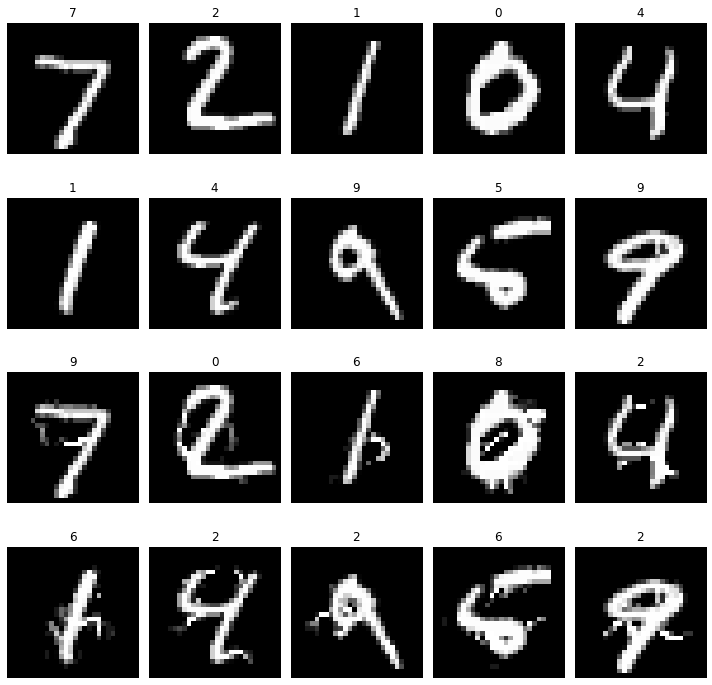

In [24]:
#plot images
plt.figure(figsize=(10, 10))

for i in range(10):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(x_test_cln[i], cmap='gray')
    ax.set_title('{:}'.format(np.argmax(y_test_cln,axis=1)[i]))
    plt.axis("off")
    
    ax = plt.subplot(4, 5, i + 11)
    plt.imshow(x_test_adv[i], cmap='gray')
    ax.set_title('{:}'.format(np.argmax(predictions_adv,axis=1)[i]))
    plt.axis("off")
    
plt.tight_layout()
plt.show()

## **Section 2 - Defence**

### **PixelDefend**

Step 1: Transform input

In [28]:
defence = PixelDefend(pixel_cnn_classifier)

x_test_cln_tp_pd = defence(x_test_cln_tp * 255)[0] / 255
x_test_cln_fp_pd = defence(x_test_cln_fp * 255)[0] / 255
x_test_adv_tp_pd = defence(x_test_adv_tp * 255)[0] / 255
x_test_adv_fp_pd = defence(x_test_adv_fp * 255)[0] / 255

TypeError: PixelCNN model must be of type Classifier.

Step 2: Evaluate the classifier on all 4 sets of data after PixelDefend

In [ ]:
predictions_cln_tp_pd = classifier.predict(x_test_cln_tp_pd)
accuracy = np.sum(np.argmax(predictions_cln_tp_pd, axis=1) == np.argmax(y_test_cln_tp_pd, axis=1)) / len(y_test_cln_tp_pd)

print("Accuracy on true positive benign test examples: {}%".format(accuracy * 100))

In [ ]:
predictions_cln_fp_pd = classifier.predict(x_test_cln_fp_pd)
accuracy = np.sum(np.argmax(predictions_cln_fp_pd, axis=1) == np.argmax(y_test_cln_fp_pd, axis=1)) / len(y_test_cln_fp_pd)

print("Accuracy on false positive benign test examples: {}%".format(accuracy * 100))

In [ ]:
predictions_adv_tp_pd = classifier.predict(x_test_adv_tp_pd)
accuracy = np.sum(np.argmax(predictions_adv_tp_pd, axis=1) == np.argmax(y_test_adv_tp_pd, axis=1)) / len(y_test_adv_tp_pd)

print("Accuracy on true positive adversarial test examples: {}%".format(accuracy * 100))

In [ ]:
predictions_cln_fp_pd = classifier.predict(x_test_adv_fp_pd)
accuracy = np.sum(np.argmax(predictions_adv_fp_pd, axis=1) == np.argmax(y_test_adv_fp_pd, axis=1)) / len(y_test_adv_fp_pd)

print("Accuracy on false positive benign test examples: {}%".format(accuracy * 100))

Optional step: Plot all data pre- and post-transformation

In [ ]:
#plot images
plt.figure(figsize=(20, 20))

ax = plt.subplot(4, 1, 1)
plt.imshow(x_test_cln_tp[0], cmap='gray')
ax.set_title('{:}'.format(np.argmax(y_test_cln_tp,axis=1)[0]))
plt.axis("off")

ax = plt.subplot(4, 1, 2)
plt.imshow(x_test_cln_tp_pd[0], cmap='gray')
ax.set_title('{:}'.format(np.argmax(y_test_cln_tp_pd,axis=1)[0]))
plt.axis("off")

ax = plt.subplot(4, 2, 1)
plt.imshow(x_test_cln_fp[0], cmap='gray')
ax.set_title('{:}'.format(np.argmax(y_test_cln_fp,axis=1)[0]))
plt.axis("off")

ax = plt.subplot(4, 2, 2)
plt.imshow(x_test_cln_fp_pd[0], cmap='gray')
ax.set_title('{:}'.format(np.argmax(y_test_cln_fp_pd,axis=1)[0]))
plt.axis("off")

ax = plt.subplot(4, 3, 1)
plt.imshow(x_test_adv_tp[0], cmap='gray')
ax.set_title('{:}'.format(np.argmax(y_test_adv_tp,axis=1)[0]))
plt.axis("off")

ax = plt.subplot(4, 3, 2)
plt.imshow(x_test_adv_tp_pd[0], cmap='gray')
ax.set_title('{:}'.format(np.argmax(y_test_adv_tp_pd,axis=1)[0]))
plt.axis("off")

ax = plt.subplot(4, 4, 1)
plt.imshow(x_test_adv_fp[0], cmap='gray')
ax.set_title('{:}'.format(np.argmax(y_test_adv_fp,axis=1)[0]))
plt.axis("off")

ax = plt.subplot(4, 4, 2)
plt.imshow(x_test_adv_fp_pd[0], cmap='gray')
ax.set_title('{:}'.format(np.argmax(y_test_adv_fp_dp,axis=1)[0]))
plt.axis("off")
    
plt.tight_layout()
plt.show()

Optional step: Compare the performance of PixelDefend against the adversary over a range of eps values

In [ ]:
eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
accuracy_original = []
accuracy_robust = []

adv_crafter = FastGradientMethod(classifier)
adv_crafter_robust = FastGradientMethod(robust_classifier)

for eps in eps_range:
    adv_crafter.set_params(**{'eps': eps})
    adv_crafter_robust.set_params(**{'eps': eps})
    x_test_adv = adv_crafter.generate(x_test[:100])
    x_test_adv_robust = adv_crafter_robust.generate(x_test[:100])
    
    predictions_original = np.argmax(classifier.predict(x_test_adv), axis=1)
    accuracy_original += [np.sum(predictions_original == np.argmax(y_test[:100], axis=1))]
    
    predictions_robust = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
    accuracy_robust += [np.sum(predictions_robust == np.argmax(y_test[:100], axis=1))]

eps_range = eps_range

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(accuracy_original), 'b--', label='Original classifier')
ax.plot(np.array(eps_range), np.array(accuracy_robust), 'r--', label='Robust classifier')

legend = ax.legend(loc='upper right', shadow=True, fontsize='large')
#legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy (%)')
plt.show()

### **Load MARVEL dataset**

In [ ]:
x_train = []
y_train = []
x_test = []
y_test = [] 
min_pixel_value = 0
max_pixel_value = 1

def marvel_class(filename):
    switcher={
        'HeavyLoadCarrier': 0,
        'CombatVessel': 1,
        'ContainerShip': 2,
        'PassengersShip': 3,
        'Ro-roCargo': 4,
        'Tanker': 5,
        'Tug': 6,
        'SupplyVessel': 7,
        'Yacht': 8 
    }
    return switcher.get(filename)

def load_training_data(filename):
    url = "/home/cyber/Desktop/Adrian/marvel_data/train_9/"+filename
    for imgname in os.listdir(url):
        img = cv2.imread(os.path.join(url,imgname))
        if img is not None:
            img = cv2.resize(img, (320,240))
            x_train.append(img/255)
            y_train.append(marvel_class(filename))
    return x_train, y_train

def load_test_data(filename):
    url = "/home/cyber/Desktop/Adrian/marvel_data/test_9/"+filename
    for imgname in os.listdir(url):
        img = cv2.imread(os.path.join(url,imgname))
        if img is not None:
            img = cv2.resize(img, (320,240))
            x_test.append(img/255)
            y_test.append(marvel_class(filename))
    return x_test, y_test

# for filename in os.listdir("/home/cyber/Desktop/Adrian/marvel_data/train_9"):
#     load_training_data(filename)
#     print(filename)

for filename in os.listdir("/home/cyber/Desktop/Adrian/marvel_data/test_9"):
    load_test_data(filename)
    print(filename)
    
#load_training_data("/home/cyber/Desktop/Adrian/marvel_data/test_9/CombatVessel")


*Modification: Convert MARVEL x_test/x_train from uint8 into float32, to enable classification*

In [ ]:
x_test = np.array(x_test, dtype=np.float32)

In [77]:
pixel_cnn_classifier = TensorFlowV2Classifier(model=pixel_cnn, input_shape=input_shape, nb_classes=0)#, input_layer=1, output_layer=10)

In [105]:
def train(model, data, optimizer):
  for x, y in data:
    with tf.GradientTape() as tape:
      # training=True is only needed if there are layers with different
      # behavior during training versus inference (e.g. Dropout).
      prediction = model(x, training=True)
      loss = loss_fn(prediction, y)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train_pixel_cnn=train(pixel_cnn, data, 'adam')

ValueError: too many values to unpack (expected 2)

In [ ]:
pixel_cnn_classifier = TensorFlowV2Classifier(model=pixel_cnn, nb_classes=10, train_step=train_pixel_cnn, input_shape=(28,28,1), clip_values=(0,1))

In [ ]:
pixel_cnn_classifier.fit(x=x_train_cln, y=y_train_cln, batch_size=64, nb_epochs=10)